# Tutorial demonstrating verification of v1 SOI index against jra55

#### Import pyLatte package

In [1]:
from pylatte import utils
from pylatte import skill

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

#### Import some plotting packages

In [3]:
import matplotlib.pyplot as plt
import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
%matplotlib inline

# A note about the methodology of pyLatte
The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [4]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# client

# Construct xarray objects for forecasts and observations

#### (The CAFE cookbook will replace these code blocks)

In [10]:
# Resampling details -----
resample_freq = 'M'
resample_method = 'mean'

# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/002_prmsl/'
obsv_filename = 'anl_surf125.002_prmsl.'

In [11]:
# Initial dates (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2002-02','2002-03' , freq='1MS')

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years
lead_times = utils.get_lead_times(FCST_LENGTH, resample_freq)

### Construct forecasts xarray object

In [12]:
# import pdb, traceback, sys

# ==================================================
# Initialize xarray object for first init_date -----
# ==================================================
with utils.timer():
    print(f'Gathering data for forecast started on {init_dates[0].month}-{init_dates[0].year}...')
    
    ds_fcst = xr.open_mfdataset(fcst_folder + 
                                '/yr' + str(init_dates[0].year) + 
                                '/mn' + str(init_dates[0].month) + 
                                '/OUTPUT.' + str(ensembles[0]) + 
                                '/' + fcst_filename, autoclose=True)
    ds_fcst.coords['ensemble'] = ensembles[0]

    for ensemble in ensembles[1:]:
        ds_temp = xr.open_mfdataset(fcst_folder + 
                                    '/yr' + str(init_dates[0].year) + 
                                    '/mn' + str(init_dates[0].month) + 
                                    '/OUTPUT.' + str(ensemble) + 
                                    '/' + fcst_filename, autoclose=True)
        # Concatenate along 'ensemble' dimension/coordinate -----
        ds_temp.coords['ensemble'] = ensemble
        ds_fcst = xr.concat([ds_fcst, ds_temp],'ensemble')

    # Resample to desired frequency and resave time as lead time -----
    ds_fcst = ds_fcst.resample(freq=resample_freq, dim='time', how=resample_method) \
                               .isel(time = range(len(lead_times)))
    ds_fcst['time'] = ds_fcst['time'].values.astype('<M8[' + resample_freq + ']')
    ds_fcst = utils.datetime_to_leadtime(ds_fcst).expand_dims('init_date')
    
# ==============================================
# Loop over remaining initialization dates -----
# ==============================================
for init_date in init_dates[1:]:
    with utils.timer():
        year = init_date.year
        month = init_date.month
        print(f'Gathering data for forecast started on {month}-{year}...')

        # There is a bug in xarray that causes an 'invalid type promotion' sometimes when concatenating 
        # The following while loop provides a work-around 
        more_ensembles = True
        first_chunk = True
        current_ensemble = 1

        while more_ensembles:
            try:
                # Initialize xarray object for first ensemble -----
                ds_temp1 = xr.open_mfdataset(fcst_folder + 
                                             '/yr' + str(year) + 
                                             '/mn' + str(month) + 
                                             '/OUTPUT.' + str(ensembles[current_ensemble-1]) + 
                                             '/' + fcst_filename, autoclose=True)
                ds_temp1.coords['ensemble'] = ensembles[current_ensemble-1]

                for ensemble in ensembles[current_ensemble:]:
                    ds_temp2 = xr.open_mfdataset(fcst_folder + 
                                                '/yr' + str(year) + 
                                                '/mn' + str(month) + 
                                                '/OUTPUT.' + str(ensemble) + 
                                                '/' + fcst_filename, autoclose=True)
                    # Concatenate along 'ensemble' dimension/coordinate -----
                    ds_temp2.coords['ensemble'] = ensemble
                    ds_temp1 = xr.concat([ds_temp1, ds_temp2],'ensemble')

                # try:
                if first_chunk:
                    ds_chunk = ds_temp1
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                # except:
                #     type, value, tb = sys.exc_info()
                #     traceback.print_exc()
                #     pdb.post_mortem(tb)

                more_ensembles = False
            except TypeError:
                if first_chunk:
                    ds_chunk = ds_temp1
                    first_chunk = False
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                current_ensemble = ensemble

        # Resample to desired frequency and resave time as lead time -----
        ds_chunk = ds_chunk.resample(freq=resample_freq, dim='time', how=resample_method) \
                           .isel(time = range(len(lead_times)))
        ds_chunk['time'] = ds_chunk['time'].values.astype('<M8[' + resample_freq + ']')
        ds_chunk = utils.datetime_to_leadtime(ds_chunk).expand_dims('init_date')
        
        # Concaneate along 'init_date' dimension/coordinate -----
        ds_fcst = xr.concat([ds_fcst, ds_chunk],'init_date')

# There seems to be a bug that re-adds the 'time' dimension after renaming - drop this -----
ds_fcst = utils.prune(ds_fcst) 

Gathering data for forecast started on 2-2002...
   Elapsed: 5.6743903160095215 sec
Gathering data for forecast started on 3-2002...
   Elapsed: 5.788890600204468 sec


#### Rechunk

In [13]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_fcst = ds_fcst.chunk(chunks={'ensemble' : len(ensembles), 'lead_time' : len(lead_times)})

   Elapsed: 0.5026588439941406 sec


### Construct observations xarray object

In [16]:
fcst_years = [pd.to_datetime(init_dates).year]
fcst_year_min = min(fcst_years)[0]
fcst_year_max = max(fcst_years)[-1] + FCST_LENGTH

# ===================================================
# Only load years for which forecast data exist -----
# ===================================================
with utils.timer():
    print(f'Gathering data for observations...')
    
    ds_jra = xr.open_mfdataset(obsv_folder + obsv_filename + str(fcst_year_min) + '*', 
                                 autoclose=True)
    for year_to_load in range(fcst_year_min+1,fcst_year_max+1):
        ds_temp2 = xr.open_mfdataset(obsv_folder + obsv_filename + str(year_to_load) + '*', 
                                     autoclose=True)
        ds_jra = xr.concat([ds_jra, ds_temp2],'initial_time0_hours')

    # Standardize naming -----
    ds_jra = ds_jra.rename({'initial_time0_hours':'time',
                                      'g0_lon_2':'lon',
                                      'g0_lat_1':'lat',
                                      'PRMSL_GDS0_MSL':'slp'})

    # Resample to desired frequency -----
    ds_jra = ds_jra.resample(freq=resample_freq, dim='time', how=resample_method)
    ds_jra['time'] = ds_jra['time'].values.astype('<M8[' + resample_freq + ']')
    
    # ===============================================
    # Stack to resemble ds_forecast coordinates -----
    # ===============================================
    ds_obsv = utils.stack_by_init_date(ds_jra,init_dates,24)
    
ds_obsv = utils.prune(ds_obsv) 

Gathering data for observations...
   Elapsed: 0.3071146011352539 sec


#### Rechunk

In [17]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_obsv = ds_obsv.chunk(chunks={'init_date' : len(init_dates)})

   Elapsed: 0.00379180908203125 sec


# Compute the SOI index

##### Tahiti and Drawin locations

In [19]:
lat_Tahiti = 17.6509
lon_Tahiti = 149.4260

lat_Darwin = 12.4634
lon_Darwin = 130.8456

##### Load climatology data
Various climatologies are/will be accessable using utils.load_climatology(). Here we use a climatology computed over the full 55 year jra reanalysis

In [20]:
jra_clim = utils.load_climatology('jra_1958-2016', 'slp', freq='M')

da_clim_Tahiti = utils.get_nearest_point(jra_clim, lat_Tahiti, lon_Tahiti)
da_clim_Darwin = utils.get_nearest_point(jra_clim, lat_Darwin, lon_Darwin)

##### Compute anomaly data
Recall that the forecast and observation data are saved as functions of lead time and initial date. The function `utils.anomalize()` computes anomalies given data and a climatology which each have a datetime dimension `time`. Thus it is necessary to first convert from the lead time/initial date format to a datetime format, then compute the anomaly, the convert back to the lead time/initial date format.  

In [21]:
anomalize = lambda data, clim: utils.datetime_to_leadtime(
                                   utils.anomalize(
                                       utils.leadtime_to_datetime(data),clim))

In [46]:
da_fcst_Tahiti = utils.get_nearest_point(ds_fcst['slp'], lat_Tahiti, lon_Tahiti) * 100
da_fcst_Tahiti_anom = da_fcst_Tahiti.groupby('init_date').apply(anomalize, clim=da_clim_Tahiti)
da_fcst_Tahiti_std = da_fcst_Tahiti_anom.std(dim='lead_time')
da_fcst_Tahiti_stdzd = da_fcst_Tahiti_anom / da_fcst_Tahiti_std

da_fcst_Darwin = utils.get_nearest_point(ds_fcst['slp'], lat_Darwin, lon_Darwin) * 100
da_fcst_Darwin_anom = da_fcst_Darwin.groupby('init_date').apply(anomalize, clim=da_clim_Darwin)
da_fcst_Darwin_std = da_fcst_Darwin_anom.std(dim='lead_time')
da_fcst_Darwin_stdzd = da_fcst_Darwin_anom / da_fcst_Darwin_std

MSD_fcst = (da_fcst_Tahiti_stdzd - da_fcst_Darwin_stdzd).std(dim='lead_time')

da_SOI_fcst = ((da_fcst_Tahiti_stdzd - da_fcst_Darwin_stdzd) / MSD_fcst).compute()

In [47]:
da_obsv_Tahiti = utils.get_nearest_point(ds_obsv['slp'], lat_Tahiti, lon_Tahiti)
da_obsv_Tahiti_anom = da_obsv_Tahiti.groupby('init_date').apply(anomalize, clim=da_clim_Tahiti)
da_obsv_Tahiti_std = da_obsv_Tahiti_anom.std(dim='lead_time')
da_obsv_Tahiti_stdzd = da_obsv_Tahiti_anom / da_obsv_Tahiti_std

da_obsv_Darwin = utils.get_nearest_point(ds_obsv['slp'], lat_Darwin, lon_Darwin)
da_obsv_Darwin_anom = da_obsv_Darwin.groupby('init_date').apply(anomalize, clim=da_clim_Darwin)
da_obsv_Darwin_std = da_obsv_Darwin_anom.std(dim='lead_time')
da_obsv_Darwin_stdzd = da_obsv_Darwin_anom / da_obsv_Darwin_std

MSD_obsv = (da_obsv_Tahiti_stdzd - da_obsv_Darwin_stdzd).std(dim='lead_time')

da_SOI_obsv = ((da_obsv_Tahiti_stdzd - da_obsv_Darwin_stdzd) / MSD_obsv).compute()

##### Compute persistence data
This requires repeating the data at the first lead time over all lead times. `utils.repeat_data()` allows us to do this

In [50]:
da_SOI_pers = utils.repeat_data(da_SOI_obsv,'lead_time')

### Plot one initialization date

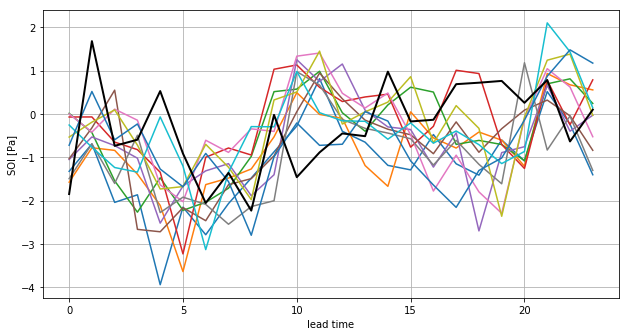

In [48]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(da_SOI_fcst['lead_time'],da_SOI_fcst.isel(init_date=[0]).squeeze())
ax.plot(da_SOI_obsv['lead_time'],da_SOI_obsv.isel(init_date=[0]).squeeze(),'k-',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('SOI [Pa]');

# Compute some skill metrics

## (Continuous) ranked probability score

In [69]:
# Specify bins for computation of cdf -----
bins = np.linspace(0,5,50)

# Compute ranked probability score -----
rps = skill.compute_rps(da_SOI_fcst, da_SOI_obsv, bins=bins, indep_dims=None, ensemble_dim='ensemble') \
           .groupby('init_date.month').mean(dim='init_date')

   Elapsed: 0.02848196029663086 sec


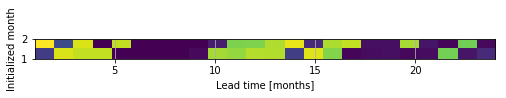

In [74]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.imshow(rps.transpose(), extent=[1,24,1,2])
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Initialized month');

## Root mean squared error

In [62]:
with utils.timer():
    rms_error = skill.compute_rms_error(da_SOI_fcst, da_SOI_obsv, 
                                        indep_dims=None, ensemble_dim='ensemble') \
                     .groupby('init_date.month').mean(dim='init_date')

   Elapsed: 0.038369178771972656 sec


   Elapsed: 0.02120685577392578 sec


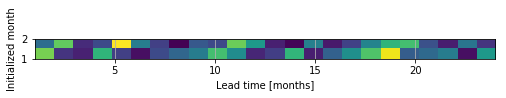

In [64]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.imshow(rms_error, extent=[1,24,1,2])
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Initialized month');

In [66]:
with utils.timer():
    rms_error = skill.compute_rms_error(da_SOI_pers, da_SOI_obsv, 
                                        indep_dims=None, ensemble_dim=None) \
                     .groupby('init_date.month').mean(dim='init_date')

   Elapsed: 0.006309032440185547 sec


   Elapsed: 0.022298574447631836 sec


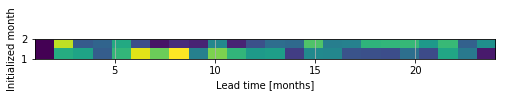

In [68]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.imshow(rms_error, extent=[1,24,1,2])
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Initialized month');

# Close dask client

In [ ]:
# with utils.timer():
#     client.close()